<a href="https://colab.research.google.com/github/ChristinaKou/CnnClassification/blob/Classifier/ChristinaKCognvitivePlus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Christina Koutsoumpa** -  Classification of tiny images CIFAR-100







***If you are going to use part of this notebook, please inform the author in advance and/or include the github link.***

Report at the end of the notebook.

# **1. Initialisation and function definitions**

Import modules

In [0]:
import os
import numpy as np
import matplotlib.pylab as plt 
import tarfile, pickle
from random import randrange

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import *
from keras.utils import plot_model
# run, upgrade tensorflow and rerun


**Paths and initialisation**

In [22]:
# Project directory
workingDir = '/Cognitive'
# Make a project folder if not existent
if not os.path.exists(workingDir):
    os.makedirs(workingDir)
os.chdir(workingDir) # Cd to this foder 
print("The current workig directory is",os.getcwd()[1:] )

%matplotlib notebook

The current workig directory is Cognitive


Functions

In [0]:
# List non hidden files in current folder
def nonHiddenfiles():
  fileList = [n_file for n_file in os.listdir() if not n_file.startswith('.')] 
  return fileList

# Unpickle file
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict


# **2. Dataset loading, unpickling and exploring**



## 2.1 Download and decompress dataset

In [24]:
# Download dataset if not already downloaded
fileList = nonHiddenfiles()
if len(fileList)==0: # Check for non hidden files
  # Donwload 
  print("Downloading data ..")
  !wget -q --show-progress https://www.cs.toronto.edu/%7Ekriz/cifar-100-python.tar.gz
  fileList = nonHiddenfiles()
  print("Dataset", fileList[-1],  "downloaded" )
else:
  # Do not download
  print("Dataset", fileList[-1], "already downloaded" )
  fileList = nonHiddenfiles()

Dataset cifar-100-python already downloaded


In [25]:
# Decompress dataset
fileList = nonHiddenfiles()
datasetFile = fileList[-1]
if datasetFile.endswith("tar.gz"):
  print("Decompressing dataset..")    
  tar = tarfile.open(datasetFile, "r:gz")    
  tar.extractall()
  tar.close()
  print("..into", tar.name)
  os.remove(tar.name) # delete compressed file
  fileList.remove(datasetFile)
else:
  print("Dataset uncompressed") 


Dataset uncompressed


## 2.2 Dataset summary

In [26]:
# Look into the folder
os.chdir(nonHiddenfiles()[-1]) 
# List non hidden content
contentList = nonHiddenfiles()
print(*contentList, sep = "\n")
#%cd ..

meta
train
file.txt~
test


In [27]:
# Unpickle data 
test = unpickle('test')
meta = unpickle('meta')
train = unpickle('train')
print(type(test), type(meta), type(train))
%cd ..

<class 'dict'> <class 'dict'> <class 'dict'>
/Cognitive


### Table

In [0]:
print("\tLABEL","\t\t\t","LENGTH\t\t", "VALUE")

# expore meta dataset
print("META")
for i in list(range(0,min(100,len(meta)))):
  print(list(meta.keys())[i],"\t\t",len(list(meta.values())[i]),"\t\t",list(meta.values())[i]), print('\n')

# expore train dataset
print("TRAIN")
for i in list(range(0,min(100,len(train)))):
  print(list(train.keys())[i],"      \t\t",len(list(train.values())[i]),"\t\t",list(train.values())[i]), print('\n')

# expore test dataset
print("TEST")
for i in list(range(0,min(100,len(test)))):
  print(list(test.keys())[i],":          \t",len(list(test.values())[i]),"\t\t", list(test.values())[i]), print('\n')


### Image examples

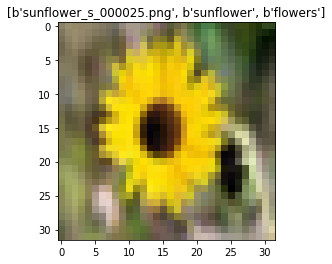

In [9]:
# Show random image examples with their filename, coarse category and fine category
%matplotlib inline
trainImages = train[b'data'].reshape(50000,3,32,32).transpose(0,2,3,1);

thisImage=randrange(len(train[b'filenames']));
plt.imshow(trainImages[thisImage].squeeze());
plt.title([train[b'filenames'][thisImage], meta[b'fine_label_names'][train[b'fine_labels'][thisImage]],meta[b'coarse_label_names'][train[b'coarse_labels'][thisImage]]] );


# 3.NN classification



Initialisation

In [0]:
# Clear any logs from previous runs
#!rm -rf ./logs/

# Make results folder
if not os.path.exists('Results'):
    os.makedirs('Results')

## 3.1. Data pre-processing

In [11]:
# type and shape of image data, min and max value
print(type(train[b'data']),train[b'data'].shape, [train[b'data'].min(),train[b'data'].max()])


<class 'numpy.ndarray'> (50000, 3072) [0, 255]


In [12]:
# Number of classses
nClasses = 100

# get and reshape dataset
trainImages = train[b'data'].reshape(50000,3,32,32).transpose(0,2,3,1).astype('float32');
testImages = test[b'data'].reshape(10000,3,32,32).transpose(0,2,3,1).astype('float32');
print(trainImages.shape,  testImages.shape)

# get labels and create output binary class matrices
trainLabels = train[b'fine_labels']
testLabels = test[b'fine_labels']
print(len(trainLabels))
# convert class label vectors to binary class matrices.
trainLabels = keras.utils.to_categorical(trainLabels, nClasses)
testLabels = keras.utils.to_categorical(testLabels, nClasses)


(50000, 32, 32, 3) (10000, 32, 32, 3)
50000


In [13]:
# Normalisation
trainImages = (trainImages - trainImages.min()) / (trainImages.max() - trainImages.min())
print('Values range :', [trainImages.min(),trainImages.max()], ', labels range',[trainLabels.min(),trainLabels.max()])


Values range : [0.0, 1.0] , labels range [0.0, 1.0]


## 3.2. Model

100-class classifier : 
CNN with 3 convolutional-maxpooling layers and 2 fully connected layers


In [14]:
# Build the CNN

classifier = Sequential()
# First convolution-maxpooling
#classifier.add(Convolution2D(32, (3, 3), input_shape = (32, 32, 3), activation = 'relu', padding='same'))
classifier.add(Conv2D(32, (3, 3), input_shape = (32, 32, 3), activation = 'relu', padding='same'))
classifier.add(MaxPooling2D(pool_size = (2, 2), strides=(2,2)))

# Second convolution-maxpooling
classifier.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
classifier.add(MaxPooling2D(pool_size = (2, 2), strides=2, padding='valid'))

# Third convolution-maxpooling
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding='same'))
classifier.add(MaxPooling2D(pool_size = (2, 2), strides=2, padding='valid'))

# Fourth convolution-maxpooling
#classifier.add(Conv2D(256, (3, 3), activation = 'relu', padding='same'))
#classifier.add(MaxPooling2D(pool_size = (2, 2), strides=2, padding='valid'))

# Flattening
classifier.add(Flatten())

# Full connection
classifier.add(Dense(256, activation = 'relu')) # sigmoid softmax
classifier.add(Dense(output_dim = nClasses, activation = 'softmax')) # sigmoid softmax

# Compiling the CNN
classifier.compile(optimizer = Adam(lr=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Print topology
classifier.summary(80)








Model: "sequential_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d_1 (Conv2D)                   (None, 32, 32, 32)              896         
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 16, 16, 32)              0           
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 16, 16, 64)              18496       
________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)      (None, 8, 8, 64)                0           
________________________________________________________________________________
conv2d_3 (Conv2D)                   (None, 8, 8, 32)                18464       
________________________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=100)`


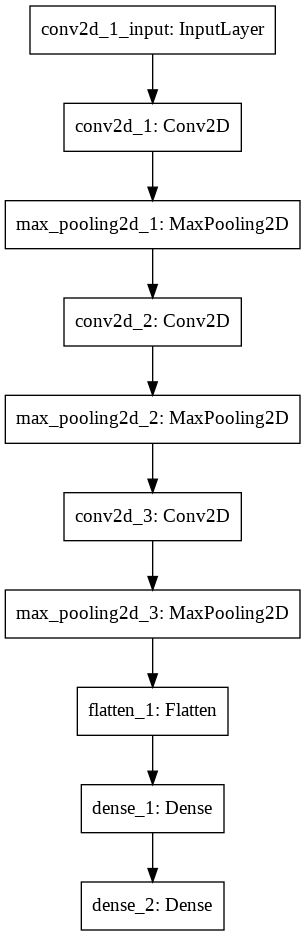

In [15]:
# Draw topology

plot_model(classifier, to_file='Results/topology.png')

## 3.2. Training

* Activation function in hidden layers : ReLU
* Loss function : categorical cross entropy
* Optimiser: Adam with learning rate 0.001 and batch size ={{batchSize}}
* Accuracy xx achieved after 150 epochs 

In [16]:
# Hyperparameters
batchSize = 20
epochsN =  200 #150
split = 0.2

# Training
history = classifier.fit(trainImages, trainLabels, validation_split = split, batch_size = batchSize, epochs = epochsN, shuffle = True, verbose=2 )

# Save model
classifier.save('Results/classifier')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 40000 samples, validate on 10000 samples
Epoch 1/200





 - 86s - loss: 3.7996 - acc: 0.1196 - val_loss: 3.3671 - val_acc: 0.1907
Epoch 2/200
 - 87s - loss: 3.0326 - acc: 0.2524 - val_loss: 2.9198 - val_acc: 0.2790
Epoch 3/200
 - 87s - loss: 2.6957 - acc: 0.3192 - val_loss: 2.8031 - val_acc: 0.3061
Epoch 4/200
 - 88s - loss: 2.4809 - acc: 0.3624 - val_loss: 2.6877 - val_acc: 0.3285
Epoch 5/200
 - 89s - loss: 2.3085 - acc: 0.3966 - val_loss: 2.6111 - val_acc: 0.3545
Epoch 6/200
 - 88s - loss: 2.1684 - acc: 0.4309 - val_loss: 2.6161 - val_acc: 0.3525
Epoch 7/200
 - 89s - loss: 2.0401 - acc: 0.4564 - val_loss: 2.6127 - val_acc: 0.3517
Epoch 8/200
 - 88s - loss: 1.9266 - acc: 0.4845 - val_loss: 2.6579 - val_acc: 0.3558
Epoch 9/200
 - 91s - loss: 1.8204 - acc: 0.5023 - val_loss: 2.7372 - val_acc: 0.3480
Epoch 10/200
 - 89s - loss: 1.7163 - acc: 0.5296 - val_loss: 2.7448 - val_acc: 0.35

# 4.Evaluation

## 4.1. Training performance

After 200 epochs 
Train loss:		0.7715357698166384
Train accuracy:		0.9066249950528145
Validation loss:	10.533059918403625
Validation accuracy:	0.2900000020414591


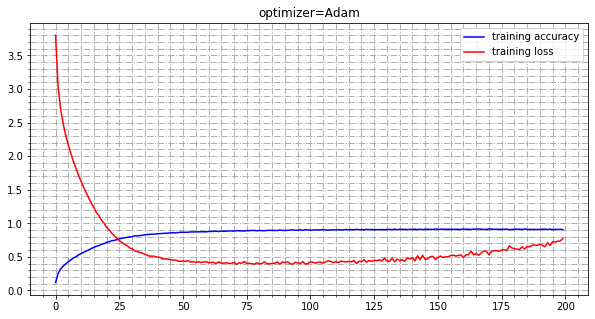

In [17]:
# Print
print('After {} epochs \nTrain loss:\t\t{}\nTrain accuracy:\t\t{}\nValidation loss:\t{}\nValidation accuracy:\t{}'.format(epochsN, history.history['loss'][-1], history.history['acc'][-1],history.history['val_loss'][-1],history.history['val_acc'][-1] ))

# Plot the loss function and the evaluation metric over the course of training
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.array(history.history['acc']), color='blue', label='training accuracy')
ax.plot(np.array(history.history['loss']), color='red', label='training loss')
ax.set_title('optimizer={}'.format('Adam'))
ax.legend(loc='upper right')
ax.minorticks_on(), ax.grid(which='both', linestyle='-.', linewidth=1)
plt.show()

# Save figure
fig.savefig('Results/performance.png')


## 4.2.Testing performance

In [18]:
# Evaluate the training and testing performance of your model 
score = classifier.evaluate(trainImages, trainLabels, verbose=2)
print('Train loss:', score[0])
print('Train accuracy:', score[1], '\n\n')

score = classifier.evaluate(testImages, testLabels, verbose=2)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 2.6316747434699
Train accuracy: 0.79558 


Test loss: 13.509920349121094
Test accuracy: 0.1618


In [0]:
#%load_ext tensorboard
#%tensorboard --logdir logs

# 5.Pickling and saving

In [0]:
# Pickle training and save 
with open("Results/training", 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

# Report
The current notebook suggests a CNN classifier for the CIFAR-100 dataset. The dataset comprises of 50000+10000 tiny images belonging to 100 classes which in turn are evenly categoried into to 20 super-classes.

The classification problem of this dataset is challenging because the resolution of the images is rather low and the number of categories is large for the given number of labeled images which makes both the extraction and categorisation of the features challenging.

Here I suggest a CNN comprising of 3 convolutional-maxpooling, 1 flattening and 2 fully connected layers including the output layer of 100 neurons which achieves image classificaiton into the 100 classes, thus also classification into the 20 superclasses. Direct classification into the 20 superclasses was even more challenging (performed several trials on this) due to the high intra-superclass variability of images. 

The proposed CNN achieves accuracy of xxx and loss function value of xx on the training dataset (after minor tuning of the hyperparameters). However, the corresponding values on the testing dataset are significantly lower which indicats possible overfitting. Tests with more layers resulted in divergence of the optimisation (training) even when different optimisers were tried (adam, sgd, mse). 

This CNN classifier can be used as a baseline for comparison with other NN.
To avoid overfitting, I would next try a ResNet achitecture which allows the use of many layers controling at the same time the aggregation of errors that account for the gradient vanishing[3]. A list of suitable methods built around Resnet and other architectures are listed in [4]. To improve the training I would also employ data augmentation and fine tuning of the hyperparameters. 










# Citations
1. https://www.cs.toronto.edu/~kriz/cifar.html (dataset)
2. https://www.tensorflow.org/tensorboard/graphs 
3. https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035
4. https://paperswithcode.com/sota/image-classification-on-cifar-100